In [4]:
import tensorflow as tf
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# data loading and cleaning

features_path = "./training_set/features/"
labels_path = "./training_set/labels/"

def load_data(img_dir):
    return np.array([cv2.imread(os.path.join(img_dir, img)) for img in sorted(os.listdir(img_dir)) if img.endswith(".jpeg")])

In [6]:
feature_imgs = load_data(features_path) # (7280, 32, 42, 3)
label_imgs = load_data(labels_path) # (3640, 32, 42, 3)

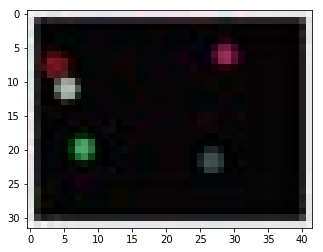

In [7]:
plt.imshow(feature_imgs[4900])

In [8]:
# scratch
num_imgs = feature_imgs.shape[0] # 7280
paired_samp = np.array(np.split(feature_imgs, num_imgs/2))
paired_samp.shape # (3640, 2, 32, 42, 3)
paired_samp[0].shape # (2, 32, 42, 3)
np.concatenate((paired_samp[0][0], paired_samp[0][1]), axis=2).shape

(32, 42, 6)

In [9]:
def concat_frames(samples):
    num_samples = samples.shape[0]
    paired_samples = np.array(np.split(samples, num_samples / 2))
    
    concatenated_frames = []
    
    for pair in paired_samples:
        concatenated_frames.append(np.concatenate((pair[0], pair[1]), axis=2))

    return np.array(concatenated_frames)

In [10]:
paired_frames = concat_frames(feature_imgs)
paired_frames.shape

(3640, 32, 42, 6)

In [11]:
tf.reset_default_graph()

In [12]:
# Convolution Layers

# individual frames are 42 w x 32 h x 3 d

X = tf.placeholder(tf.float32, [None, 32, 42, 6], name="X")

# the 'label' is the frame following the last one from above
y = tf.placeholder(tf.float32, [None, 32, 42, 3], name="y")

# Convolution Layer #1
# output is 32 channels, 32 rows, 42 cols
conv1 = tf.layers.conv2d(
          inputs=X,
          filters=32,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)

# Pooling Layer #1
# output is 32 channels, 16 rows, 21 cols
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

# Convolution Layer #2
# output is 64 channels, 16 rows, 21 cols
conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=64,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)

# Pooling Layer #2
# output is 64 channels, 8 rows, 11 cols = 5632
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2, padding="same") 
pool2_flat = tf.reshape(pool2, [-1, 8 * 11 * 64])


In [13]:
label_imgs_flat = tf.reshape(label_imgs, [-1, 32 * 42 * 3])
label_imgs_flat.shape

TensorShape([Dimension(3640), Dimension(4032)])

In [14]:
# Set Hyperparameters
learning_rate = 0.01
epochs = 5
batch_size = 140
num_samples = 3640

In [15]:
# Autoencoder 
d1_neurons = 300
d2_neurons = 150
d3_neurons = 300

num_outputs = 32 * 42 * 3

# He Initialization
he_init = tf.contrib.layers.variance_scaling_initializer()

# L2 Regularization
l2_reg = tf.contrib.layers.l2_regularizer(0.0001)

# Dense Layer #1
dense1 = tf.layers.dense(inputs=pool2_flat, 
                         units=d1_neurons, 
                         kernel_initializer=he_init, 
                         kernel_regularizer=l2_reg, 
                         activation=tf.nn.relu)

# Dense Layer #2
dense2 = tf.layers.dense(inputs=dense1, 
                         units=d2_neurons, 
                         kernel_initializer=he_init, 
                         kernel_regularizer=l2_reg, 
                         activation=tf.nn.relu)

# Dense Layer #3
dense3 = tf.layers.dense(inputs=dense2, 
                         units=d3_neurons, 
                         kernel_initializer=he_init, 
                         kernel_regularizer=l2_reg, 
                         activation=tf.nn.relu)

# Dense Layer #4
dense4 = tf.layers.dense(inputs=dense3, 
                         units=num_outputs, 
                         kernel_initializer=he_init, 
                         kernel_regularizer=l2_reg, 
                         activation=None)


reconstruction_loss = tf.reduce_mean(tf.square(dense4 - tf.cast(tf.reshape(y, [-1, 4032]), tf.float32)))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [16]:
# shuffle training set
indices = np.random.permutation(num_samples)

shuffled_x = paired_frames[indices]
shuffled_labels = label_imgs[indices]

In [17]:
def get_next_batch(batch_size, iteration):
    ceiling = batch_size * (1 + iteration)
    floor = ceiling - batch_size
    
    X_batch = shuffled_x[floor:ceiling] 
    y_batch = label_imgs[floor:ceiling] 
    return X_batch, y_batch

In [18]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    for epoch in range(epochs):
        n_batches = num_samples // batch_size
        
        for iteration in range(n_batches):            
            X_batch, y_batch = get_next_batch(batch_size, iteration)
            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch, y: y_batch})   
        print("epoch", epoch, "MSE:", loss_train)                   

epoch 0 MSE: 705.2136
epoch 1 MSE: 312.57376
epoch 2 MSE: 297.41327
epoch 3 MSE: 291.40906
epoch 4 MSE: 290.049
